<a href="https://colab.research.google.com/github/ctezna/notebooks/blob/main/covid_papers_Topic_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivos Trabajo-3 - ST 1800 - ARI <font color='blue'>EAFIT-2021-I**</font>

## Integrantes:

* Emanuel Travanti
* José Carlos Díaz
* Carlos Tezna
* Felipe Carrasquilla

# **Alternativa 3:** Categorización de tópicos y clasificacion de textos <font color='red'>**COVID-19**</font>

## Ciclo de procesamiento
###1. Preparación de texto (general)
Tokenización, remoción de caracteres especiales, manejo de nulls, n-grams, stopwords, stem/lemma, etc.

###2. Análisis descriptivo básico (general)
Columnas, tipos, cantidad, agrupaciones categóricas sobre diferentes campos, min-max-avg,etc.
###3. Representación de documentos y características
BoW & TF-IDF, opcionalmente word2vec o doc2vec
###4. Selección y ejecución de modelos
####4.1 Detección de topicos
Empleando LDA
###5. Evaluación
####5.1 Detección de topicos
###5. Visualización
####5.1 Detección de topicos
###6. Analisis de resultados
Desde analisis exploratorio

# Setup

### Install libs and Load data

In [52]:
! pip install nltk
! pip install pyLDAvis

In [53]:
#https://drive.google.com/uc?export=download&id=1cEovVDwbqNngTlGFgOkmsVFcHMAp961m
!wget --load-cookies /tmp/cookies.txt\
 "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies\
  /tmp/cookies.txt --keep-session-cookies --no-check-certificate\
   'https://docs.google.com/uc?export=download&id=1cEovVDwbqNngTlGFgOkmsVFcHMAp961m'\
    -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cEovVDwbqNngTlGFgOkmsVFcHMAp961m"\
     -O 'metadata.csv' && rm -rf /tmp/cookies.txt

--2021-03-24 01:29:19--  https://docs.google.com/uc?export=download&confirm=HeQy&id=1cEovVDwbqNngTlGFgOkmsVFcHMAp961m
Resolving docs.google.com (docs.google.com)... 216.58.192.110, 2607:f8b0:4026:803::200e
Connecting to docs.google.com (docs.google.com)|216.58.192.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/0s673ql1onagt2ov3d0rsedlu7fsnmic/b7rpmqu314bl5pal8cq83seo0o73oe97/1616549325000/06785497291657377943/18401225702628580553Z/1cEovVDwbqNngTlGFgOkmsVFcHMAp961m?e=download [following]
--2021-03-24 01:29:19--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/0s673ql1onagt2ov3d0rsedlu7fsnmic/b7rpmqu314bl5pal8cq83seo0o73oe97/1616549325000/06785497291657377943/18401225702628580553Z/1cEovVDwbqNngTlGFgOkmsVFcHMAp961m?e=download
Resolving doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)... 216.58.192.97, 2607:f8b0:4026:803::2001
Connecting to doc-0s

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import string
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

eng_stopwords = stopwords.words('english')

stop_words = set(eng_stopwords)
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

file = 'metadata.csv'
metadata_df = pd.read_csv(file, dtype=str)
# Remove the columns
papers = metadata_df.drop(columns=['doi', 'pmcid', 'pubmed_id', 'sha', 'source_x',
                              'license', 'mag_id', 'who_covidence_id', 'arxiv_id',
                              'url', 'pdf_json_files', 'pmc_json_files', 's2_id'], axis=1)
papers = papers.dropna()
# sample only 100 papers
papers = papers.sample(100)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have","you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Implementacion

###1. Preparación de texto (general)
Tokenización, remoción de caracteres especiales, manejo de nulls, n-grams, stopwords, stem/lemma, etc.

In [56]:
papers.head()

,cord_uid,title,abstract,publish_time,authors,journal
363678,5dub8nv7,Development of a Multiplex RT-qPCR for the Det...,"Since the initial detection of H5N1, a highly ...",2020-01-15,"Le, Tran Bac; Kim, Hye Kwon; Na, Woonsung; Le,...",Viruses
308347,z7leh72x,Recovery of endoscopy services in the era of C...,The COVID-19 pandemic has had a profound impac...,2020,"Bhandari, Pradeep; Subramaniam, Sharmila; Bour...",Gut
381821,i77acnv4,Increased expression of hypoxia-induced factor...,BACKGROUND: COVID-19 counts 46 million people ...,2020-12-21,"Taniguchi-Ponciano, Keiko; Vadillo, Eduardo; M...",Annals of medicine
80497,9xthz7s4,Prevalence of Dumping Syndrome After Laparosco...,BACKGROUND Dumping syndrome is a well-known si...,2019,"Ahmad, Arif; Kornrich, Daphne Baldwin; Krasner...",Obesity surgery
146999,7gzqrhqg,Comprehensive review of implications of COVID-...,Coronavirus disease-2019 (COVID-19) has emerge...,2020,"Madan, Ankit; Siglin, Joshua; Khan, Aleem",Cancer Med


In [57]:
# Remove punctuation
papers['paper_text_processed'] = papers['abstract'].map(lambda x: re.sub('[,\.!?]', '', str(x)))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

363678    since the initial detection of h5n1 a highly p...
308347    the covid-19 pandemic has had a profound impac...
381821    background: covid-19 counts 46 million people ...
80497     background dumping syndrome is a well-known si...
146999    coronavirus disease-2019 (covid-19) has emerge...
Name: paper_text_processed, dtype: object

In [58]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [59]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [60]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [61]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [62]:
# Cleaning data - remove punctuation from every text
texts = metadata_df.drop(columns=['doi', 'pmcid', 'pubmed_id', 'sha', 'source_x',
                              'license', 'mag_id', 'who_covidence_id', 'arxiv_id',
                              'url', 'pdf_json_files', 'pmc_json_files', 's2_id'], axis=1)
texts = texts.dropna()
texts = texts.sample(10000)
texts = list(texts['abstract'].copy())
sentences = []
# Go through each text in turn
for ii in range(len(texts)):
    sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                        repl='', 
                        string=x
                       ).strip().split(' ') for x in texts[ii].split('\n') 
                      if not x.endswith('writes:')]
    sentences = [x for x in sentences if x != ['']]
    texts[ii] = sentences

In [63]:
# concatenate all sentences from all texts into a single list of sentences
all_sentences = []
for text in texts:
    all_sentences += text

In [64]:
from gensim.models.phrases import Phraser, Phrases
# Phrase Detection
# Give some common terms that can be ignored in phrase detection
# For example, 'state_of_affairs' will be detected because 'of' is provided here: 
common_terms = ["of", "with", "without", "and", "or", "the", "a"]
# Create the relevant phrases from the list of sentences:
phrases = Phrases(all_sentences, common_terms=common_terms)
# The Phraser object is used from now on to transform sentences
bigram = Phraser(phrases)
# Applying the Phraser to transform our sentences is simply
all_sentences = list(bigram[all_sentences])

In [66]:
#Import all the dependencies
from gensim.models.doc2vec import TaggedDocument
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

tagged_data = list(tagged_document(texts))
#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(texts_data)]

In [67]:
tagged_data[0]

TaggedDocument(words=[['BACKGROUND', 'Numerous', 'nucleic', 'acid', 'amplification', 'assays', 'utilizing', 'different', 'target', 'genes', 'of', 'the', 'SARSCoV2', 'genome', 'have', 'received', 'emergency', 'use', 'authorization', 'EUA', 'by', 'the', 'United', 'States', 'Food', 'and', 'Drug', 'Administration', 'FDA', 'Limited', 'data', 'are', 'available', 'comparing', 'the', 'test', 'performance', 'characteristics', 'of', 'these', 'assays', 'METHODS', 'A', 'diagnostic', 'comparison', 'study', 'was', 'performed', 'to', 'evaluate', 'the', 'performance', 'of', 'the', 'Cepheid', 'Xpert', 'Xpress', 'SARSCoV2', 'assay', 'compared', 'to', 'the', 'Hologic', 'Panther', 'Fusion', 'SARSCoV2', 'assay', 'using', 'clinical', 'nasopharyngeal', 'specimens', 'Agreement', 'between', 'the', 'two', 'assays', 'was', 'assessed', 'by', 'overall', 'positive', 'and', 'negative', 'percent', 'agreement', 'and', "Cohen's", 'kappa', 'coefficient', 'RESULTS', 'A', 'total', 'of', '104', '54', 'positive', 'and', '50

###2. Análisis descriptivo básico (general)
Columnas, tipos, cantidad, agrupaciones categóricas sobre diferentes campos, min-max-avg,etc.

#### Helper functions

In [68]:
# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');
    plt.show()

#### Visualizations

In [69]:
print ("The shape of the dataset : ", metadata_df.shape)

The shape of the dataset :  (482221, 19)


Statistical Summary of Article Lengths
      count         mean         std  min  25%     50%     75%       max
0  482221.0  1005.508644  871.017491  1.0  3.0  1069.0  1616.0  122392.0


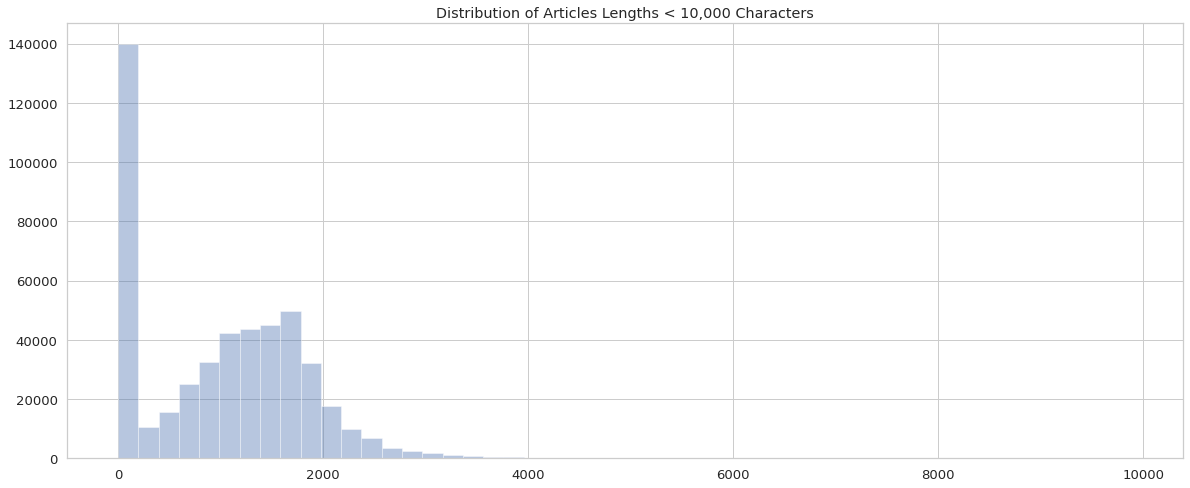

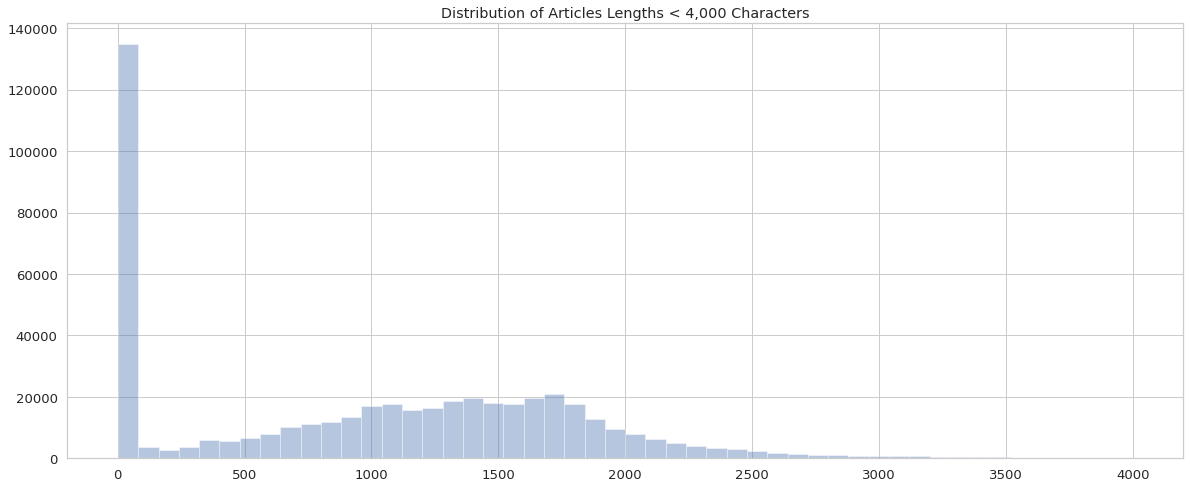

In [70]:
lengths = pd.Series([len(str(x)) for x in metadata_df['abstract']])
print('Statistical Summary of Article Lengths')
print(pd.DataFrame(lengths.describe()).T)

sns.distplot(lengths[lengths<10000], kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

sns.distplot(lengths[lengths<4000], kde=False)
plt.title('Distribution of Articles Lengths < 4,000 Characters')
plt.show()

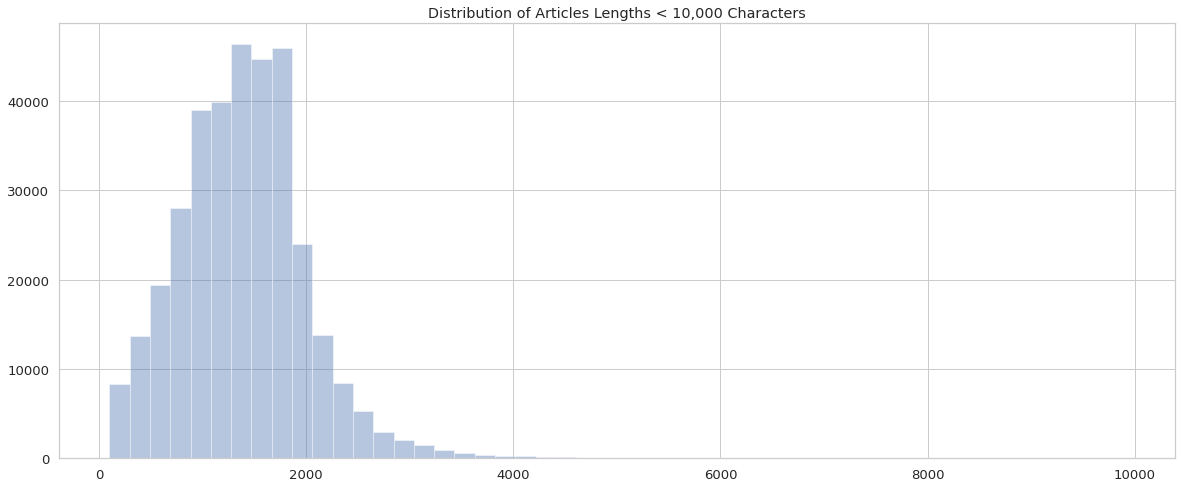

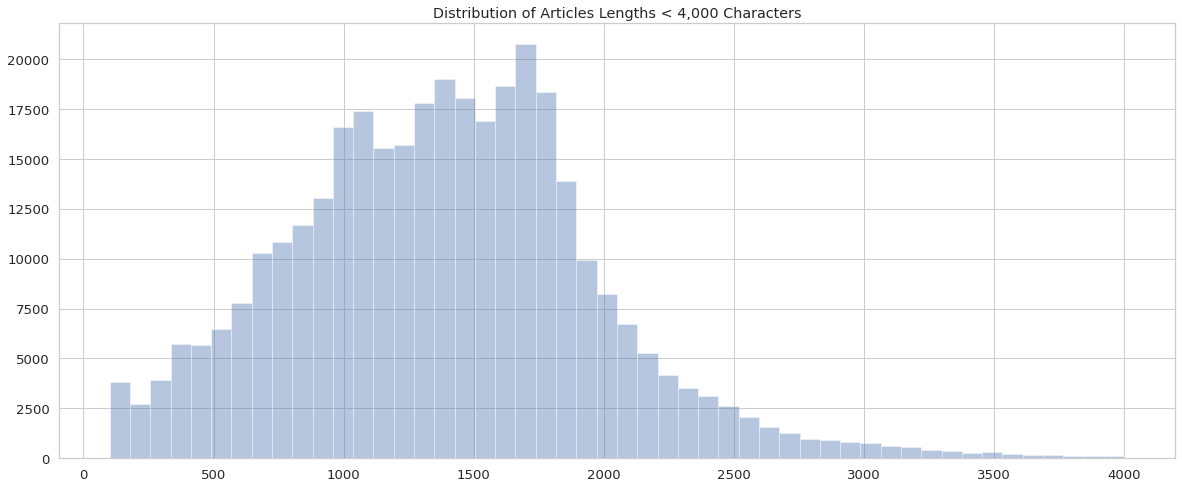

In [71]:
sns.distplot(lengths[(lengths<10000) & (lengths > 100)], kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

sns.distplot(lengths[(lengths<4000) & (lengths > 100)], kde=False)
plt.title('Distribution of Articles Lengths < 4,000 Characters')
plt.show()

In [72]:
metadata_df['year'] = metadata_df['publish_time'].apply(lambda x: str(x).split('-')[0])
article_years = metadata_df['year'].value_counts()[:20]

df_years = article_years.reset_index(name='count').rename(columns={'index':'year'})
#df_years.head()

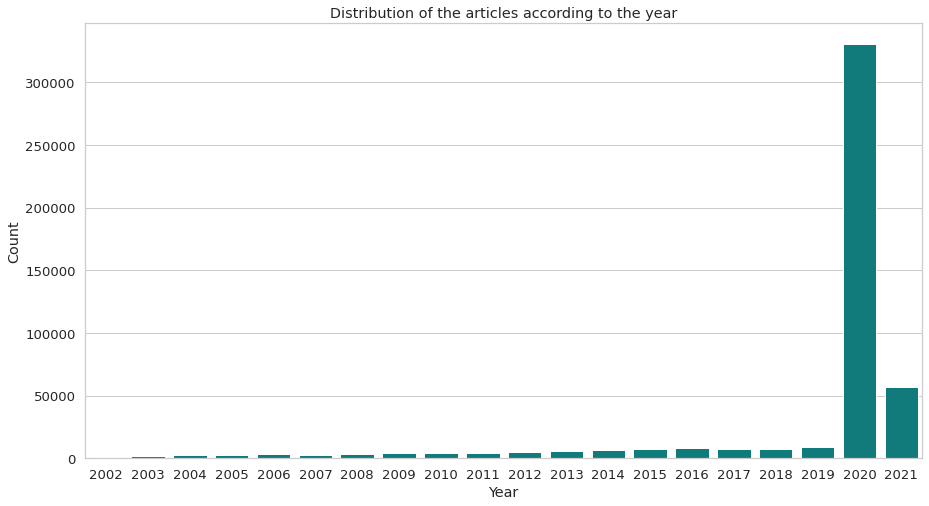

In [73]:
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'whitegrid')
order = df_years.sort_values(by=['year'])['year'].array
sns_year = sns.barplot(x='year', y='count', data=df_years, order=order, color='darkcyan')
sns_year.set(xlabel = "Year", ylabel = "Count", title = "Distribution of the articles according to the year");

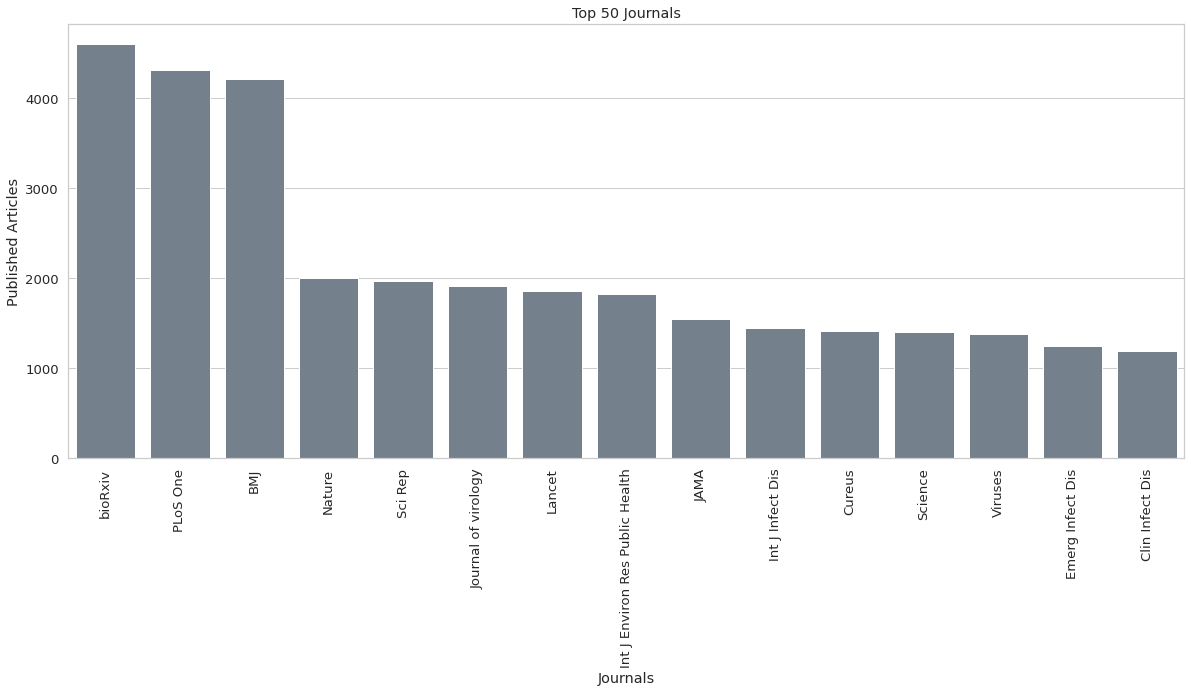

In [74]:
plt.rcParams['figure.figsize'] = [20, 8]
publication_count = metadata_df['journal'].value_counts()[0:15]
pub_top_50 = sns.barplot(x = list(publication_count.index), y = (publication_count.values), color = 'slategrey')
pub_top_50.set(xlabel = "Journals", ylabel = "Published Articles", title = "Top 50 Journals")
plt.setp(pub_top_50.get_xticklabels(), rotation = 90);
plt.show()

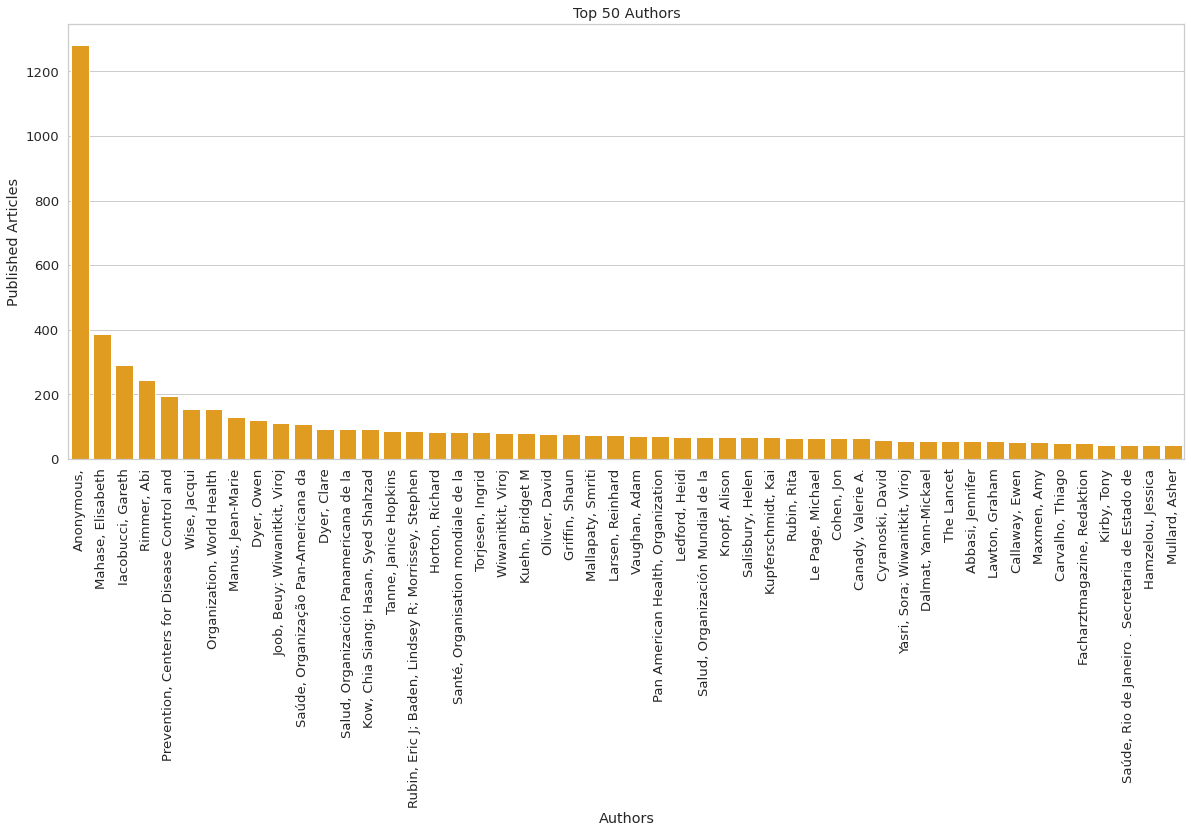

In [75]:
plt.rcParams['figure.figsize'] = [20, 8]
author_count = metadata_df['authors'].value_counts()[0:50]
author_top_50 = sns.barplot(x = list(author_count.index), y = (author_count.values), color = 'orange')
author_top_50.set(xlabel = "Authors", ylabel = "Published Articles", title = "Top 50 Authors")
plt.setp(author_top_50.get_xticklabels(), rotation = 90);
plt.show()

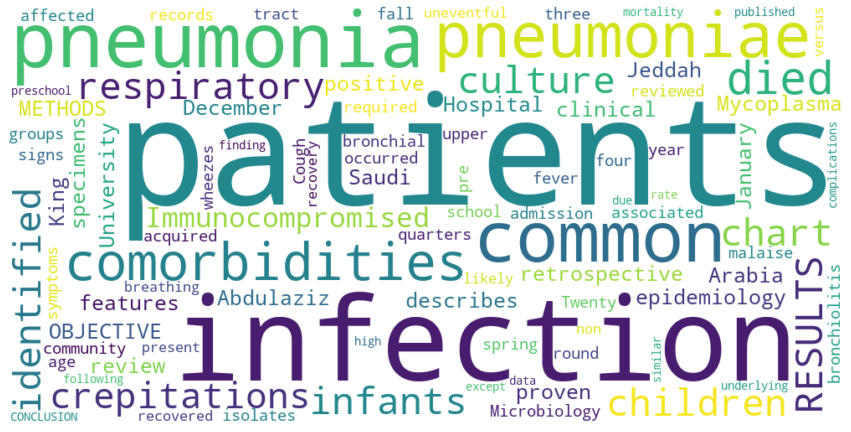

In [76]:
word_cloud(metadata_df['abstract'][0])

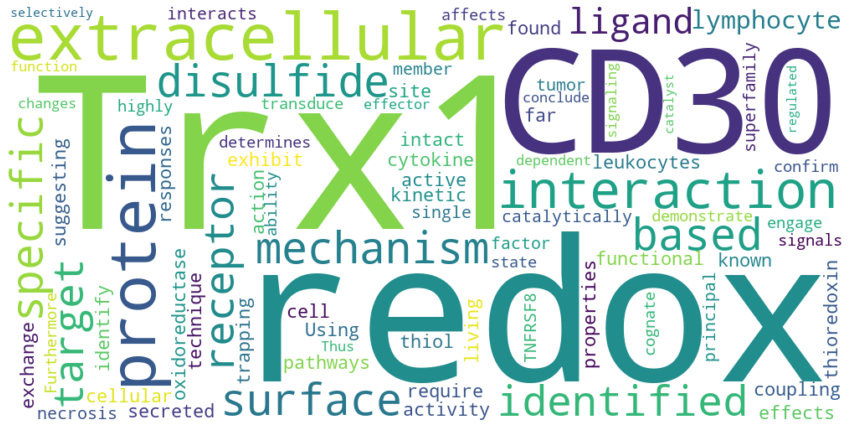

In [77]:
word_cloud(metadata_df['abstract'][100])

In [78]:
def extract_entities(save_file=False):
  from tqdm import tqdm, tqdm_notebook
  nlp = spacy.load('en',
                  disable=['parser', 
                            'tagger',
                            'textcat'])
  frames = []
  #for i in tqdm_notebook(range(df.size)):
  for i in tqdm_notebook(range(10000)):
      doc = str(metadata_df.iloc[i]['abstract'])
      text_id = str(metadata_df.iloc[i]['title'])
      doc = nlp(doc)
      ents = [(e.text, e.start_char, e.end_char, e.label_) 
              for e in doc.ents 
              if len(e.text.strip(' -—')) > 0]
      frame = pd.DataFrame(ents)
      frame['id'] = text_id
      frames.append(frame)

  entities = pd.concat(frames)

  entities.columns = ['Text','Start','Stop','Type','id']
  if save_file:
    entities.to_csv('./entities.csv', index=False)
    
  return entities

entities = extract_entities(save_file=False)

In [79]:
#entities = pd.read_csv('./entities.csv')
entities.head()

,Text,Start,Stop,Type,id
0,40,95.0,97.0,CARDINAL,Clinical features of culture-proven Mycoplasma...
1,Mycoplasma,127.0,137.0,GPE,Clinical features of culture-proven Mycoplasma...
2,King Abdulaziz University Hospital,163.0,197.0,ORG,Clinical features of culture-proven Mycoplasma...
3,Jeddah,199.0,205.0,GPE,Clinical features of culture-proven Mycoplasma...
4,Saudi Arabia,207.0,219.0,GPE,Clinical features of culture-proven Mycoplasma...


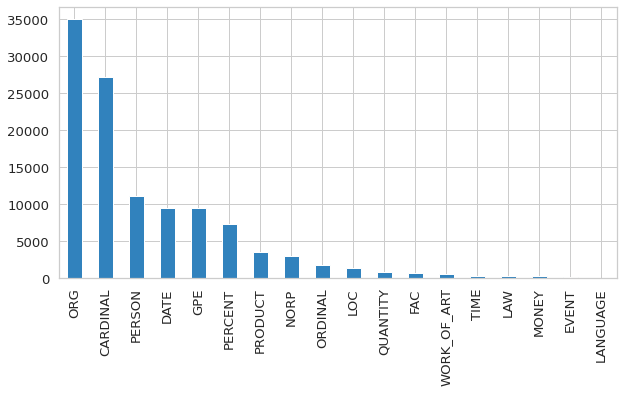

In [80]:
plt.figure(figsize=(10,5))
entities['Type'].value_counts().plot(kind='bar', colormap='tab20c')

2    king abdulaziz university hospital
0                                   pvm
1                                   pcr
0                             nidovirus
5                                   rna
Name: Text, dtype: object


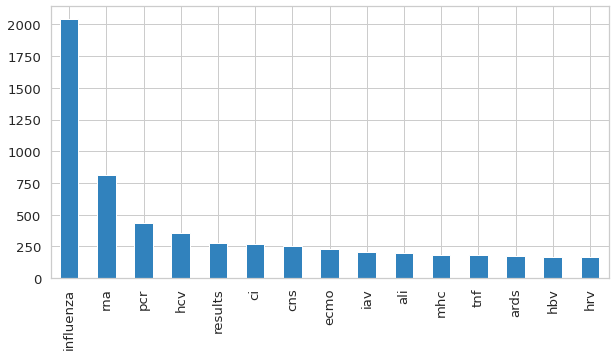

In [81]:
orgs = entities[entities['Type'] == 'ORG']['Text'].apply(lambda x: x.lower().replace('the ', ''))
print(orgs.head())
plt.figure(figsize=(10,5))
fig = orgs.value_counts()[:15].plot(kind='bar', colormap='tab20c').get_figure()

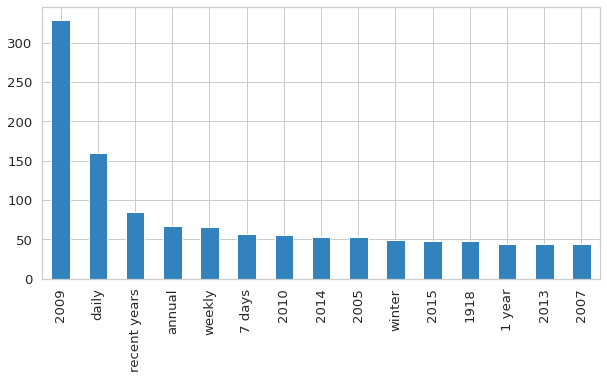

In [82]:
dates = entities[entities['Type'] == 'DATE']['Text']
plt.figure(figsize=(10,5))
fig = dates.value_counts()[:15].plot(kind='bar', colormap='tab20c').get_figure()

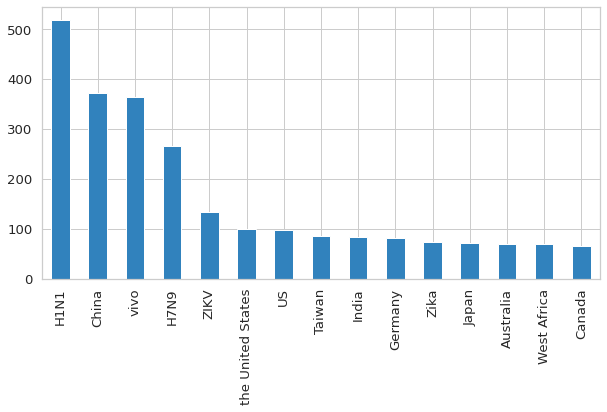

In [83]:
places = entities[entities['Type'] == 'GPE']['Text']
plt.figure(figsize=(10,5))
fig = places.value_counts()[:15].plot(kind='bar', colormap='tab20c').get_figure()

In [84]:
import spacy
from spacy import displacy

nlp = spacy.load('en')
user_doc = metadata_df.iloc[500]['abstract'][:150]
user_doc = nlp(user_doc)
displacy.render(user_doc, style='dep', jupyter=True, options={'distance':120})

In [85]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)
def matcher_component(doc):
    matches = matcher(doc)
    return doc

try:
  nlp.add_pipe(matcher_component,last=True)
except ValueError:
  pass
doc = nlp(metadata_df.iloc[0]['abstract'][:1500])
displacy.render(doc, style='ent', jupyter=True)

In [86]:
doc = metadata_df.iloc[10000]['abstract'][0:1500]
doc = nlp(doc)
displacy.render(doc, style='ent', jupyter=True)

###3. Representación de documentos y características
BoW & TF-IDF, opcionalmente word2vec o doc2vec

BoW & TF-IDF

In [87]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [88]:
from gensim.models import TfidfModel
idf_model = TfidfModel(corpus=corpus, id2word=id2word)

Word2Vec

In [89]:
from gensim.models import Word2Vec
import time
start = time.time()
w2v_model = Word2Vec(all_sentences, 
                 min_count=2,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=8,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=10)       # Number of epochs training over corpus
end = time.time()
print('Train time: ', end - start)

Train time:  39.83678150177002


In [90]:
w2v_model.wv.most_similar('risk')

[('high_risk', 0.745899498462677),
 ('higher_risk', 0.7435837984085083),
 ('rates', 0.7353053689002991),
 ('increased_risk', 0.7268798351287842),
 ('mortality', 0.721511960029602),
 ('rate', 0.7110679745674133),
 ('severity', 0.7020492553710938),
 ('risks', 0.697312593460083),
 ('likelihood', 0.6891802549362183),
 ('burden', 0.6727322340011597)]

In [91]:
analogy = w2v_model.wv.most_similar(positive=['coughing', 'fever'], negative=['covid'])
print(analogy)

[('sneeze', 0.8140038251876831), ('respiratory_symptoms', 0.7807706594467163), ('fever_cough', 0.7746162414550781), ('bleeding', 0.757671594619751), ('cough', 0.7538561820983887), ('dyspnea', 0.744041919708252), ('lesions', 0.7262468338012695), ('signs', 0.720787763595581), ('GGO', 0.7182756662368774), ('hyperbaric', 0.7155921459197998)]


In [92]:
w2v_model.wv.distance('sick', 'ill')

0.12626159191131592

In [93]:
w2v_model.wv.similarity('sick', 'ill')

0.8737384

In [94]:
w2v_model.wv.closer_than('sick', 'ill') # returns entities that are more similar to system than close

[]

FastText Algorithm - “Bag of Tricks for Efficient Text Classification”:
paper: http://aclweb.org/anthology/E17-2068 (Facebook Research)

In [95]:
from gensim.models.fasttext import FastText
import time
start = time.time()
fasttext_model = FastText(all_sentences, 
                 min_count=2,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=8,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=10) 
end = time.time()
print('Train time: ', end - start)

Train time:  188.34697008132935


In [96]:
fasttext_model.wv.most_similar('risk') # appears to be related to levenshtein distance

[('risk’', 0.991763710975647),
 ('[risk', 0.9900811314582825),
 ('risk”', 0.9892673492431641),
 ('risky', 0.9890004992485046),
 ('brisk', 0.9801106452941895),
 ('oddsrisk', 0.9691869020462036),
 ('riskfree', 0.9526113271713257),
 ('goodrisk', 0.9491457343101501),
 ('Risk', 0.9439451694488525),
 ('atrisk', 0.9431060552597046)]

Doc2Vec

In [97]:
from gensim.models.doc2vec import Doc2Vec
max_epochs = 100
vec_size = 20
alpha = 0.025

d2v_model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
tagged_data = list(tagged_document(texts))

d2v_model.build_vocab(tagged_data)
from tqdm import tqdm, tqdm_notebook
for epoch in tqdm_notebook(range(max_epochs)):
    d2v_model.train(tagged_data,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.iter)
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

d2v_model.save("d2v.model")

In [98]:
d2v_model = Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
sample_text = 'COVID-19 vaccines help our bodies develop immunity to the virus\
 that causes COVID-19 without us having to get the illness. Different types of\
  vaccines work in different ways to offer protection. But with all types of\
   vaccines, the body is left with a supply of “memory” T-lymphocytes as well\
    as B-lymphocytes that will remember how to fight that virus in the future.'
test_data = word_tokenize(sample_text.lower())
v1 = d2v_model.infer_vector(test_data)
print("V1_infer", v1)

V1_infer [ 0.01513858  0.09646086  0.00857867  0.09563402  0.04765047  0.09382677
  0.03978788  0.05220933 -0.00434596  0.02454513  0.04152778 -0.04270558
  0.02850964  0.06995327 -0.01916464  0.00945975 -0.01601192  0.09110983
  0.0109903  -0.04342199]


In [99]:
# to find most similar doc using tags
similar_doc = d2v_model.docvecs.most_similar(1)
print(similar_doc)

[(90, 0.6798186898231506), (80, 0.6328393220901489), (71, 0.586687445640564), (4, 0.5826888084411621), (98, 0.5812487602233887), (0, 0.5543514490127563), (56, 0.553795576095581), (64, 0.546754002571106), (79, 0.5461918711662292), (9, 0.5366522669792175)]


In [100]:
# to find vector of doc in training data using tags or in other words, 
#printing the vector of document at index 1 in training data
print(d2v_model.docvecs[1])

[ -4.7175045  -12.341632     3.6215007    3.8505764    9.010891
   8.884551     5.8131146    0.01933604   9.147219     5.288363
  -1.8422282    2.73732     -9.292216    -1.9641997    2.05656
   3.785651     2.7261512    8.809572     1.113495    10.8182125 ]


###4. Selección y ejecución de modelos

####4.1 Detección de topicos
Empleando LDA

Base Model

In [101]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [102]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"game" + 0.009*"base" + 0.009*"pandemic" + 0.008*"medical" + '
  '0.008*"patient" + 0.008*"learner" + 0.008*"molecular" + 0.007*"cd" + '
  '0.007*"include" + 0.007*"result"'),
 (1,
  '0.018*"patient" + 0.017*"group" + 0.011*"use" + 0.009*"endoscopy" + '
  '0.009*"infection" + 0.008*"respiratory" + 0.007*"study" + 0.007*"virus" + '
  '0.006*"stem" + 0.006*"cell"'),
 (2,
  '0.013*"patient" + 0.013*"covid" + 0.011*"viral" + 0.011*"virus" + '
  '0.010*"infection" + 0.008*"protein" + 0.008*"clinical" + 0.007*"present" + '
  '0.007*"test" + 0.007*"use"'),
 (3,
  '0.015*"patient" + 0.011*"covid" + 0.010*"disease" + 0.010*"case" + '
  '0.009*"stroke" + 0.009*"treatment" + 0.008*"number" + 0.007*"country" + '
  '0.007*"result" + 0.007*"gene"'),
 (4,
  '0.015*"residue" + 0.011*"protein" + 0.010*"patient" + 0.010*"conserve" + '
  '0.009*"cd" + 0.008*"drug" + 0.008*"high" + 0.007*"vaccine" + 0.007*"rbd" + '
  '0.007*"prescription"'),
 (5,
  '0.017*"patient" + 0.016*"covid" + 0.009*"i

###5. Evaluación



####5.1 Detección de topicos


Base Scores

In [103]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                     dictionary=id2word, coherence='c_v')
coherence_lda_initial = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_initial)


Coherence Score:  0.3188092474894908


In [104]:
log_perplexity = lda_model.log_perplexity(corpus)
print('\nLog Perplexity: ', log_perplexity)


Log Perplexity:  -7.562573780900309


Parameter Tuning

In [105]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [106]:
import numpy as np
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [107]:
import time
start = time.time()
# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i], 
                                              dictionary=id2word, k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
end = time.time()
print(end-start)

1002.6503462791443


In [108]:
pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

Results

In [109]:
#model_results_df = pd.read_csv('lda_tuning_results.csv')
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.240641
1,75% Corpus,2,0.01,0.31,0.242896
2,75% Corpus,2,0.01,0.61,0.240641
3,75% Corpus,2,0.01,0.91,0.240641
4,75% Corpus,2,0.01,symmetric,0.240641


Optimal Parameters based on Maximum Coherence Score

In [110]:
best_params = model_results_df[model_results_df['Coherence'] ==\
                 model_results_df['Coherence'].max()]
best_params.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
528,100% Corpus,10,0.91,0.91,0.394721


In [111]:
if best_params.iloc[0]['Alpha'] == 'asymmetric' or best_params.iloc[0]['Alpha'] == 'symmetric':
  _Alpha = str(best_params.iloc[0]['Alpha'])
else:
  _Alpha =  float(best_params.iloc[0]['Alpha'])
if best_params.iloc[0]['Beta'] == 'symmetric':
  _Beta =  str(best_params.iloc[0]['Beta'])
else:
  _Beta = float(best_params.iloc[0]['Beta'])

In [112]:
alphas = model_results_df['Alpha'].unique()
betas = model_results_df['Beta'].unique()

In [113]:
def get_model_results_df(vs, alpha, beta):
  df = model_results_df[model_results_df['Validation_Set'] == vs]
  df = df[df['Alpha'] == alpha]
  df = df[df['Beta'] == beta]
  return df

In [114]:
results_df = get_model_results_df(best_params.iloc[0]['Validation_Set'],
                                  best_params.iloc[0]['Alpha'],
                                  best_params.iloc[0]['Beta'])
results_df.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
288,100% Corpus,2,0.91,0.91,0.256840
318,100% Corpus,3,0.91,0.91,0.241122
348,100% Corpus,4,0.91,0.91,0.311756
378,100% Corpus,5,0.91,0.91,0.318121
408,100% Corpus,6,0.91,0.91,0.333847
438,100% Corpus,7,0.91,0.91,0.343055
468,100% Corpus,8,0.91,0.91,0.334865
498,100% Corpus,9,0.91,0.91,0.320010
528,100% Corpus,10,0.91,0.91,0.394721


Optimal K (number of topics) based on Maximum Coherence

<Figure size 720x360 with 0 Axes>

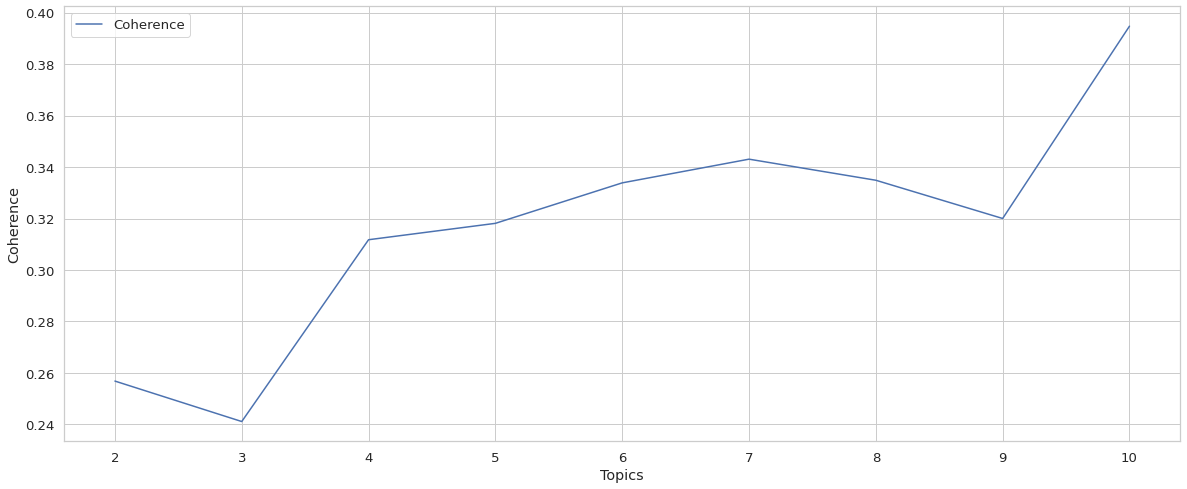

In [115]:
plt.figure(figsize=(10,5))
results_df.plot('Topics', 'Coherence', kind='line', 
                xlabel='Topics', ylabel='Coherence')

In [116]:
for a in alphas:
  for b in betas:
    vs = '100% Corpus'
    _df = get_model_results_df(vs, a, b)
    title = 'Alpha: {}, Beta: {}'.format(a, b)
    #_df.plot('Topics', 'Coherence', kind='line', title=title, 
                #xlabel='Topics', ylabel='Coherence')

Tuned Model

In [117]:
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           workers=4,
                                           num_topics=int(best_params.iloc[0]['Topics']), 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=_Alpha,
                                           eta=_Beta)

Evaluation

In [118]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=data_lemmatized,
                                     dictionary=id2word, coherence='c_v')
coherence_lda_final = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_final)


Coherence Score:  0.3947208511501802


In [119]:
coherence_change = ((coherence_lda_final - coherence_lda_initial)/coherence_lda_initial) * 100
print('Change: ', coherence_change, '%')

Change:  23.810979216715392


In [120]:
log_perplexity_final = lda_model_final.log_perplexity(corpus)
print('\nLog Perplexity: ', log_perplexity_final)


Log Perplexity:  -7.69747373110817


In [ ]:
perp_change = ((log_perplexity_final - log_perplexity)/log_perplexity) * 100
print('Change: ', perp_change, '%')

###6. Visualización


####6.1 Detección de topicos



In [121]:
import pyLDAvis.gensim_models as ldavis
import pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = ldavis.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.054215 -0.032051       1        1  28.092409
3     -0.040422  0.036176       2        1  19.597003
9     -0.003799  0.018452       3        1  14.704972
0      0.021451  0.000445       4        1   7.959238
2      0.006368 -0.008382       5        1   7.888935
7      0.009717 -0.009923       6        1   7.205312
4      0.017209 -0.001104       7        1   4.287101
1      0.012883 -0.003547       8        1   4.222525
6      0.017326  0.000151       9        1   3.968370
8      0.013482 -0.000217      10        1   2.074135, topic_info=          Term       Freq      Total Category  logprob  loglift
19      health  23.000000  23.000000  Default  30.0000  30.0000
390    protein   8.000000   8.000000  Default  29.0000  29.0000
760         cd   5.000000   5.000000  Default  28.0000  28.0000
605       male   3.000000   3.000000  Default  27.0000  27.0000
306    medical   8.000000   8.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
270     single   0.151647   4.432968  Topic10  -7.1851   0.5004
1379   conduct   0.151452   4.513346  Topic10  -7.1864   0.4811
791    several   0.151230   5.397141  Topic10  -7.1878   0.3008
1247  specific   0.150018   4.548614  Topic10  -7.1959   0.4638
1029  receptor   0.149628   5.006595  Topic10  -7.1985   0.3653

[520 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2405      8  0.359614         abuse
752       4  0.281528  accumulation
1372      5  0.317533           ace
520       1  0.251446          acid
520       2  0.251446          acid
...     ...       ...           ...
139       3  0.165927        worker
139       6  0.331855        worker
2394      6  0.331981          wrap
2042      1  0.232310         write
2042      3  0.464620         write

[822 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 10, 1, 3, 8, 5, 2, 7, 9])

###7. Analisis de resultados
Desde analisis exploratorio